In [145]:
import cvxpy as cp
import numpy as np

import torch
import torch.nn as nn
from model import TwolayerNet, MLP, AbstainNet
from torch.utils.data import DataLoader
from utils import load_data

import os
import time
from options import args_parser
from scipy.optimize import milp, Bounds
import matplotlib.pyplot as plt

from scipy.optimize import LinearConstraint

**load data**

In [146]:
class namespace:
    def __init__(self):
        self.batch_size=128
        self.device='cuda:1'
        self.epoch=30000
        self.hidden_dim=300
        self.input_dim=108
        self.load_from_disk=True
        self.lr=0.0005
        self.seed=1
        self.fairness_notion="DP"
        self.attribute="sex"
        self.type_of_abstain="prob"

args = namespace()

args.model_path = "../data/OptimalClassifier"
args.data_path = "../data/adult"

train_data, test_data = load_data(args)

**load functions**

In [147]:
def load_optimal(args):
    model = MLP(args)

    checkpoint = torch.load(os.path.join(args.model_path, "model_state.pth"), map_location="cpu")
    model.load_state_dict(checkpoint)

    model.to("cpu")
    model.eval()

    return model
def load_abstain(args):
    model = AbstainNet(args)
    
    model_file = os.path.join("../data/AbstainClassifier", "abstain_classifier_" + \
                            args.type_of_abstain+"_" + \
                            args.fairness_notion + "_" + \
                            args.attribute + ".pth")
    
    checkpoint = torch.load(model_file, map_location="cpu")
    model.load_state_dict(checkpoint)
    
    model.to("cpu")
    model.eval()
    
    return model

def predict_abstain(model, data, pred_labels):
    X = data.X.numpy()
    X = np.column_stack((X, pred_labels))
    log_probs = model(torch.from_numpy(X).to(torch.float))
    return log_probs.detach().cpu().numpy().flatten()

def predict(model, data):
    log_probs = model(data.X)
    return ((log_probs[:, 1] >= 0.5) * 1).detach().cpu().numpy(), log_probs[:, 1].detach().cpu().numpy()

def formatted(numbers):
    return [f"{num*100:.2f}%" for num in numbers]

def plot_stats(
    y,
    pred_labels,
    pred_fair,
    g1_indices, 
    g2_indices,
    wbi
):
    
    n = pred_labels.shape[0]

    g1_num = g1_indices.shape[0]
    g2_num = g2_indices.shape[0]
    total_error = pred_labels != y
    g1_error = (pred_labels != y)[g1_indices]
    g2_error = (pred_labels != y)[g2_indices]
    
    g1_error_rate = np.sum(g1_error) / g1_num
    g2_error_rate = np.sum(g2_error) / g2_num
    total_error_rate = np.sum(total_error) / n
    
    g1_fair_error_rate = np.sum((pred_fair != y)[g1_indices]) / g1_num
    g2_fair_error_rate = np.sum((pred_fair != y)[g2_indices]) / g2_num
    total_fair_error_rate = np.sum(pred_fair != y)  / n

    g1_bi_error_rate = np.sum(wbi[g1_indices] * g1_error) / np.sum(wbi[g1_indices])
    g2_bi_error_rate = np.sum(wbi[g2_indices] * g2_error) / np.sum(wbi[g2_indices])
    total_bi_error_rate = np.sum(wbi * total_error) / np.sum(wbi)



    optimal_accu = [1 - total_error_rate, 1 - g1_error_rate, 1 - g2_error_rate]
    fair_accu = [1 - total_fair_error_rate, 1 - g1_fair_error_rate, 1 - g2_fair_error_rate]
    bi_accu = [
        1 - total_bi_error_rate,
        1 - g1_bi_error_rate,
        1 - g2_bi_error_rate
    ]

    optimal_fairness = [
        np.sum(pred_labels) / n, 
        np.sum(pred_labels[g1_indices]) / g1_num, 
        np.sum(pred_labels[g2_indices]) / g2_num
    ]
    fair_fairness = [
        np.sum(pred_fair == 1) / n,
        np.sum((pred_fair == 1)[g1_indices]) / g1_num,
        np.sum((pred_fair == 1)[g2_indices]) / g2_num
    ]
    bi_fairness = [
        np.sum(wbi * pred_labels) / n,
        np.sum((wbi * pred_labels)[g1_indices]) / g1_num,
        np.sum((wbi * pred_labels)[g2_indices]) / g2_num,
    ]


    #Abstain rate
    optimal_abstain_rate = [0, 0, 0]
    fair_abstain_rate = [0, 0, 0]
    bi_abstain_rate = [
        1 - np.sum(wbi) / n, 
        1 - np.sum(wbi[g1_indices]) / g1_num, 
        1 - np.sum(wbi[g2_indices]) / g2_num,
    ]

    # plt.bar(["", "b", "c"],[1 - total_error_rate, 1 - g1_error_rate, 1 - g2_error_rate])
    plt.rcParams.update({'font.size': 15})

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    #accuracy
    bar_width = 0.25
    x_labels = ["Overall", "G1", "G2"]
    x_pos = np.arange(len(x_labels))
    ax[0,0].bar(x_pos - bar_width, optimal_accu, width=bar_width, label='Opt. Clas.')
    ax[0,0].bar(x_pos, fair_accu, width=bar_width, label='Fair Clas.')
    ax[0,0].bar(x_pos + bar_width, bi_accu, width=bar_width, label='Binary')
    ax[0,0].set_ylim([0.7, 1])
    ax[0,0].set_ylabel("Accuracy")
    ax[0,0].set_title("Accuracy")
    ax[0,0].set_xticks(x_pos)
    ax[0,0].set_xticklabels(x_labels)
    ax[0,0].legend()


    #fairness
    bar_width = 0.25
    x_labels = ["Overall", "G1", "G2"]
    x_pos = np.arange(len(x_labels))
    ax[0,1].bar(x_pos - bar_width, optimal_fairness, width=bar_width, label='Opt. Clas.')
    ax[0,1].bar(x_pos, fair_fairness, width=bar_width, label='Fair Clas.')
    ax[0,1].bar(x_pos + bar_width, bi_fairness, width=bar_width, label='Binary')
    # ax[0,1].set_ylim([0.85, 1])
    ax[0,1].set_ylabel('$P(\\hat{y} = 1 | G)$')
    ax[0,1].set_title("Demographic Parity")
    ax[0,1].set_xticks(x_pos)
    ax[0,1].set_xticklabels(x_labels)
    ax[0,1].legend()

    #proportion
    ax[1,0].pie([g1_num, g2_num], labels=['G1', 'G2'], autopct='%1.1f%%', startangle=90)
    ax[1,0].set_title('Proportion')

    #abstain rate
    bar_width = 0.25
    x_labels = ["Overall", "G1", "G2"]
    x_pos = np.arange(len(x_labels))
#     ax[1,1].bar(x_pos - bar_width, optimal_abstain_rate, width=bar_width, label='Opt. Clas.')
#     ax[1,1].bar(x_pos, prob_abstain_rate, width=bar_width, label='Prob.')
    ax[1,1].bar(x_pos, bi_abstain_rate, width=bar_width, label='Binary')
    # ax[0,1].set_ylim([0.85, 1])
    ax[1,1].set_ylabel('$P(\\hat{y} = 1 | G)$')
    ax[1,1].set_title("Abstain Rate")
    ax[1,1].set_xticks(x_pos)
    ax[1,1].set_xticklabels(x_labels)
    ax[1,1].legend()


    fig.suptitle(args.attribute + " as Sensitive Attribute(G1=Male, G2=Female, "+ '$\delta=$' + str(delta) + ', $\epsilon=$' + str(epsilon) +")", fontsize=30)

    print("==Optimal Classifier==\n")
    print("Accuracy", " ".join(formatted(optimal_accu)))
    print("P(\hat{y} = 1 | G)", " ".join(formatted(optimal_fairness)))
    print("Abstain Rate", " ".join(formatted(optimal_abstain_rate)))
    print()
    
    print("==Fair Classifier==\n")
    print("Accuracy", " ".join(formatted(fair_accu)))
    print("P(\hat{y} = 1 | G)", " ".join(formatted(fair_fairness)))
    print("Abstain Rate", " ".join(formatted(fair_abstain_rate)))

    print()

    print("==Abstain as Binary==\n")
    print("Accuracy", " ".join(formatted(bi_accu)))
    print("P(\hat{y} = 1 | G)", " ".join(formatted(bi_fairness)))
    print("Abstain Rate", " ".join(formatted(bi_abstain_rate)))

**load optimal classifier and get stats**

In [148]:
data = train_data
optimal_classifier = load_optimal(args)
pred_labels, pred_probs = predict(optimal_classifier, data)
# np.save("../data/adult/optimal_labels.npy", pred_labels)
pred_labels_test, _ = predict(optimal_classifier, test_data)
# np.save("../data/adult/test_optimal_labels.npy", pred_labels_test)

**IP ptimazation function**

In [149]:
def IP(delta, epsilon, eta, data):

    X = data.X.numpy()
    y = data.y.numpy().astype(int)

    n = X.shape[0]
    g2_indices = np.where(X[:, 64] == 1)[0]
    g1_indices = np.where(X[:, 65] == 1)[0]

    g1_v = (X[:, 65] == 1) * 1
    g2_v = (X[:, 64] == 1) * 1

    g1_num = g1_indices.shape[0]
    g2_num = g2_indices.shape[0]
    total_error = pred_labels != y
    g1_error = (pred_labels != y)[g1_indices]
    g2_error = (pred_labels != y)[g2_indices]
    g1_error_rate = np.sum(g1_error) / g1_num
    g2_error_rate = np.sum(g2_error) / g2_num
    total_error_rate = np.sum(total_error) / n

    a = total_error * 1

    b1 = pred_labels * g1_v
    b2 = pred_labels * g2_v
    c1 = np.stack(
        [
            (b1 / g1_num - b2 / g2_num), 
            (b2 / g2_num - b1 / g1_num),
        ]
    )
    cons1 = epsilon * np.ones(2)

    c2 = np.stack([g1_v, g2_v])
    cons2 = np.array([(1 - delta) * g1_num, (1 - delta) * g2_num])

    a1 = (pred_labels != y) * g1_v
    a2 = (pred_labels != y) * g2_v
    c3 = np.stack([
        (a1 - (g1_error_rate + eta) * g1_v),
        (a2 - (g2_error_rate + eta) * g2_v)
    ])
    cons3 = np.zeros(2)

    lower_bounds = np.zeros_like(a)
    upper_bounds = np.ones_like(a)

    constraints = [
        LinearConstraint(c1, ub=cons1),
        LinearConstraint(c2, lb=cons2),
        LinearConstraint(c3, ub=cons3),
    ]
    integrality = np.ones_like(a)
    res = milp(
        c=a, 
        constraints=constraints, 
        integrality=integrality, 
        bounds=Bounds(lower_bounds, upper_bounds)
    )
    wn = res.x
    return wn

def train_fair(epsilon, lbd, data):

    X = data.X.numpy()
    y = data.y.numpy().astype(int)

    n = X.shape[0]
    g2_indices = np.where(X[:, 64] == 1)[0]
    g1_indices = np.where(X[:, 65] == 1)[0]

    g1_v = (X[:, 65] == 1) * 1
    g2_v = (X[:, 64] == 1) * 1

    g1_num = g1_indices.shape[0]
    g2_num = g2_indices.shape[0]
    total_error = pred_labels != y
    
    a = 1 - (total_error * 2) 
    print("a", a.shape)
    
    g1_hat = g2_num * g1_v
    g2_hat = g1_num * g2_v
    g1_tilde = g1_hat * (1 - 2 * pred_labels)
    g2_tilde = g2_hat * (1 - 2 * pred_labels)
    g1_bar = g1_hat * pred_labels
    g2_bar = g2_hat * pred_labels

    c1 = np.stack(
        [
            g1_tilde - g2_tilde, 
            g2_tilde - g1_tilde,
            np.ones_like(pred_labels)
        ]
    )
    cons1 = np.array(
        [
            g1_num * g2_num * epsilon + np.sum(g2_bar) - np.sum(g1_bar),
            g1_num * g2_num * epsilon + np.sum(g1_bar) - np.sum(g2_bar),
            lbd * n
        ]
    )


    lower_bounds = np.zeros_like(a)
    upper_bounds = np.ones_like(a)

    constraints = [
        LinearConstraint(c1, ub=cons1),
    ]
    integrality = np.ones_like(a)
    res = milp(
        c=a, 
        constraints=constraints, 
        integrality=integrality, 
        bounds=Bounds(lower_bounds, upper_bounds)
    )
    wn = res.x
    return wn

**Solve and plot, tune hyperparameter here**

In [157]:
delta = 0.3
epsilon = 0.03
eta = 0
lbd = 1

a (39552,)
0.13791970064724918
0.7717940938511327


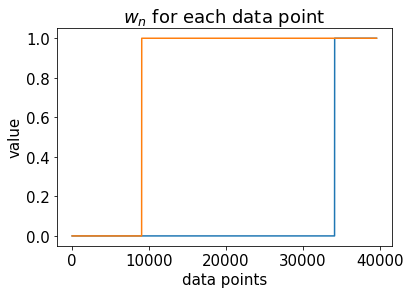

In [151]:
#solve IP
qn = train_fair(epsilon, lbd, train_data)
wn = IP(delta, epsilon, eta, train_data)

if qn is None:
    print("Not feasible!")
else:
    plt.plot(np.sort(qn))
    plt.title("$q_n$ for each data point")
    plt.xlabel("data points")
    plt.ylabel("value")
    print(np.sum(qn) / qn.shape[0])
    
if wn is None:
    print("Not feasible!")
else:
    plt.plot(np.sort(wn))
    plt.title("$w_n$ for each data point")
    plt.xlabel("data points")
    plt.ylabel("value")
    print(np.sum(wn) / wn.shape[0])

In [152]:
pred_fair = qn * (1 - pred_labels) + (1 - qn) * pred_labels

==Optimal Classifier==

Accuracy 93.21% 92.30% 95.69%
P(\hat{y} = 1 | G) 49.35% 58.01% 25.92%
Abstain Rate 0.00% 0.00% 0.00%

==Fair Classifier==

Accuracy 92.77% 100.00% 73.20%
P(\hat{y} = 1 | G) 57.39% 58.19% 55.20%
Abstain Rate 0.00% 0.00% 0.00%

==Abstain as Binary==

Accuracy 96.81% 95.66% 99.05%
P(\hat{y} = 1 | G) 28.11% 28.92% 25.92%
Abstain Rate 22.82% 30.00% 3.39%


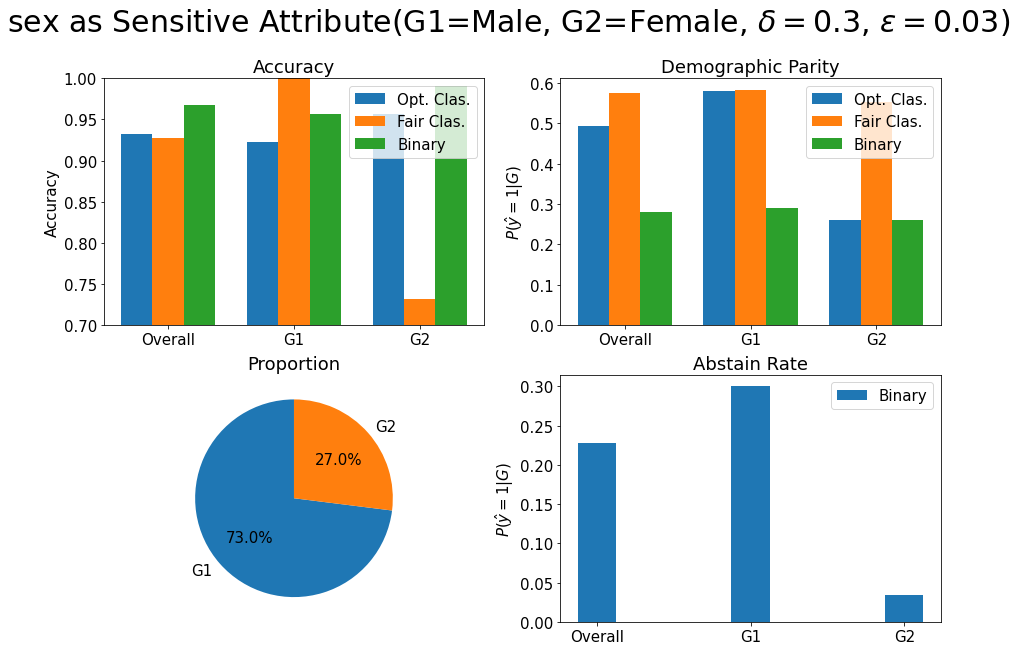

In [154]:
X = data.X.numpy()
y = data.y.numpy().astype(int)

g2_indices = np.where(X[:, 64] == 1)[0]
g1_indices = np.where(X[:, 65] == 1)[0]

plot_stats(
    y,
    pred_labels,
    pred_fair,
    g1_indices, 
    g2_indices,
    wn
)


In [156]:
np.save("../data/FairClassifier/DP_labels.npy", pred_fair)